# Hierarchical Clustering

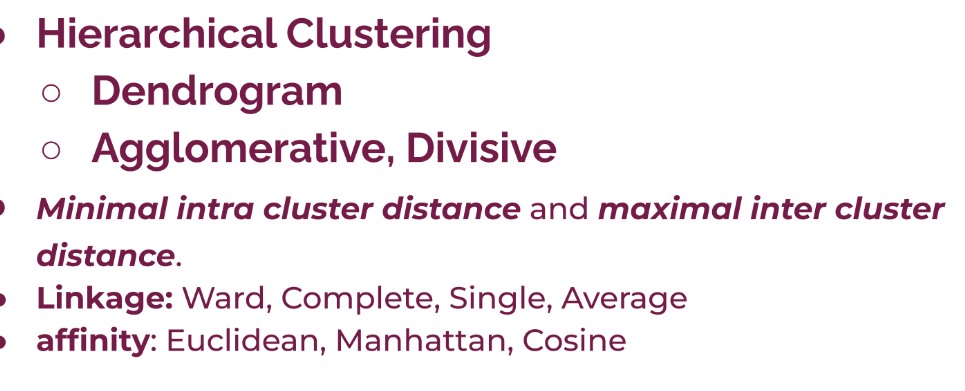

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("iris.csv")

In [3]:
df.head()

# Hierarchical cluster içinde outlier değerler problemdir. Datanın gereksiz çok fazla kümeye bölünmesine sebep olabilir.

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## Exploratory Data Analysis and Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [5]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


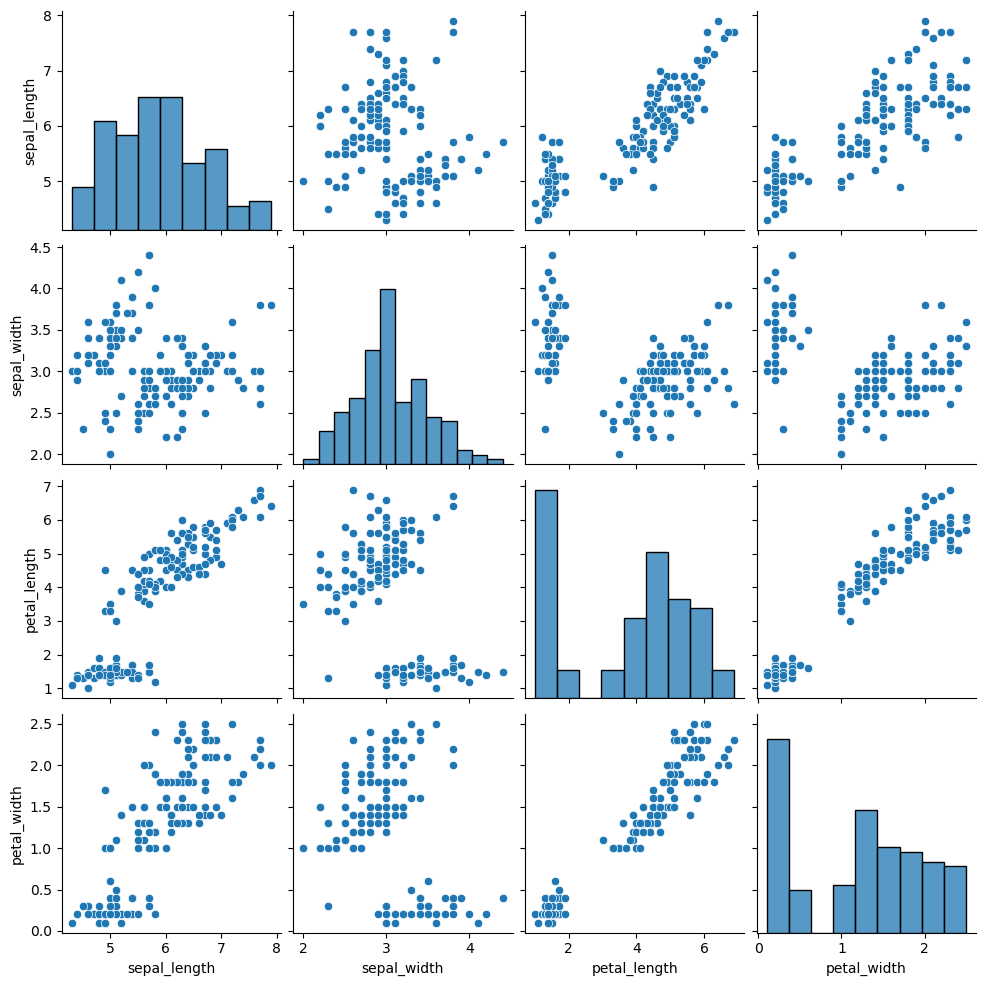

In [6]:
sns.pairplot(df);

# datamız kümelemeye meyilli mi değil mi meyilliyse kaç kümeye bölebilirim ? Scatterplot'a bakarak bir fikir edinebiliriz.
# minimal intra cluster distance and maximal inter cluster distance diye belirttiğimiz ideal kümeleme mantığını
# clustering porblemlerinin her aşamasında aklımızdan çıkarmamalıyız.

## Scaling Data

**The Hierarchical Cluster algorithm definitely needs scaling**. However, if all our features are in the same/similar range, **there is no need to scale the data**. For these data, scaling may cause worse results in some cases. You should try data both with and without scale and continue with whichever one has good results.

## Hopkins Test

- Hopkins test, a statistical test for randomness of a variable.
- Null Hypothesis (Ho) : Data points are generated by non-random, uniform distribution (implying no meaningful clusters)
- Alternate Hypothesis (Ha): Data points are generated by random data points (presence of clusters)
- The more close 0, the more available to separate clusters

In [7]:
#!pip install pyclustertend

In [8]:
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd


def hopkins(data_frame, sampling_size):
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.

    Parameters
    ----------
    data_frame : numpy array
        The input dataset
    sampling_size : int
        The sampling size which is used to evaluate the number of DataFrame.

    Returns
    ---------------------
    score : float
        The hopkins score of the dataset (between 0 and 1)

    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """

    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)

    # Sample n observations from D : P

    if sampling_size > data_frame.shape[0]:
        raise Exception(
            'The number of sample of sample is bigger than the shape of D')

    data_frame_sample = data_frame.sample(n=sampling_size)

    # Get the distance to their neirest neighbors in D : X

    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]

    # Randomly simulate n points with the same variation as in D : Q.

    max_data_frame = data_frame.max()
    min_data_frame = data_frame.min()

    uniformly_selected_values_0 = np.random.uniform(min_data_frame[0], max_data_frame[0], sampling_size)
    uniformly_selected_values_1 = np.random.uniform(min_data_frame[1], max_data_frame[1], sampling_size)

    uniformly_selected_observations = np.column_stack((uniformly_selected_values_0, uniformly_selected_values_1))
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(min_data_frame[i], max_data_frame[i], sampling_size)
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)

    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)

    # Get the distance to their neirest neighbors in D : Y

    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations_df, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist

    # return the hopkins score

    x = sum(data_frame_sample_distances_to_nearest_neighbours)
    y = sum(uniformly_df_distances_to_nearest_neighbours)

    if x + y == 0:
        raise Exception('The denominator of the hopkins statistics is null')

    return x / (x + y)[0]

In [11]:
X = df.copy()

In [12]:
hopkins(X, X.shape[0])

0.17006741514647722

## Dendrogram

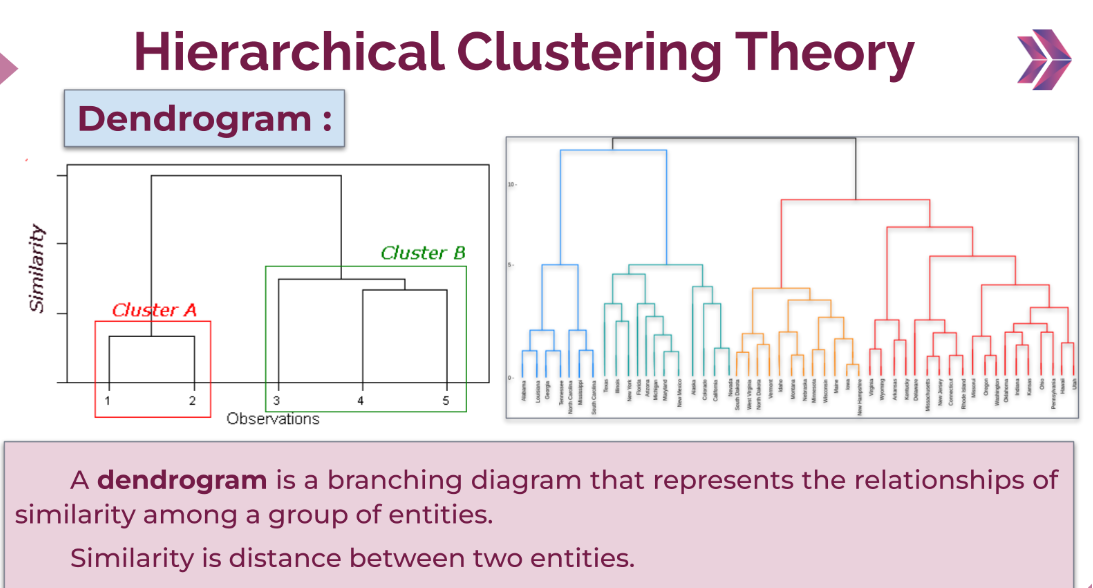

- Tree-like hierarchical representation of clusters is called a dendrogram.   
- It illustrates the arrangement of the clusters produced by the corresponding analyses.

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

# affinity (yakınlık) hyper-parametresi gözlemler arası mesafenin nasıl ölçüleceğini belirtir. Defaultu euclidean'dır.
# linkage hyper-parametresi Bu mesafelerin neye göre (ward, compelete, single, average) ölçüleceğini belirtir.

In [14]:
# dendrogram()

# dendogram benden datayı isterken aynı zamanda mesafelerin neye göre ölçüleceği bilgisini de ister.
# Bu sebeple linkage fonksiyonu içine hem datamızı tanımlayıp hemde ölçümün neye göre yapılacağı belitilerek. linkage
# fonksiyonu dendogram içerine verilir. Bu bilgiler ışığında dendogram gözlemleri kümelere atar ve bu atama işlemlerini bir 
# dallanma şeklinde bize sunar.

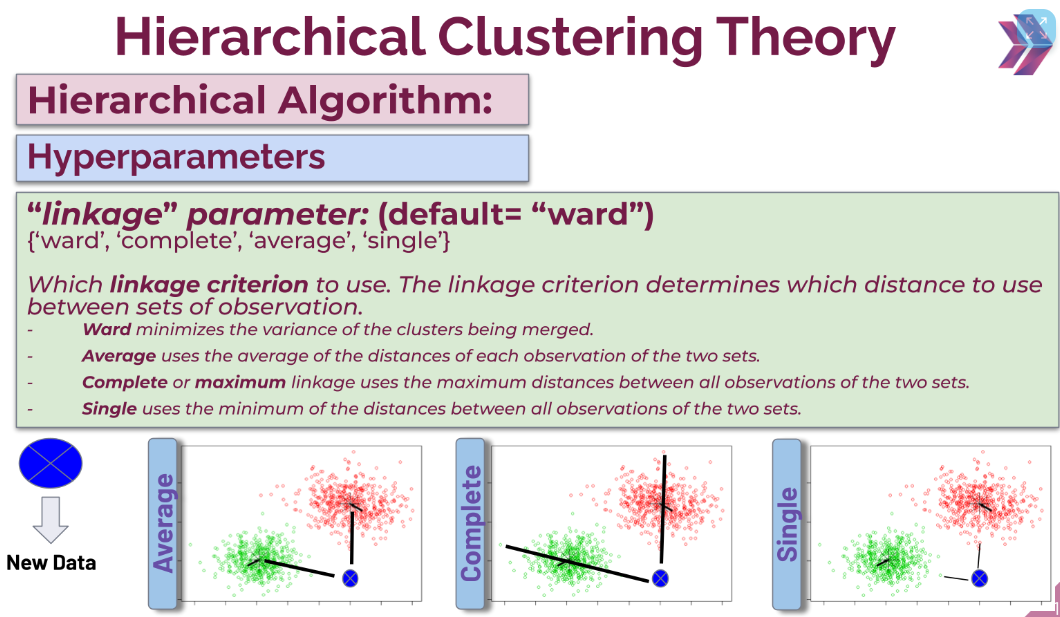

**“linkage” parameter: (default= “ward”)**

  {‘ward’, ‘complete’, ‘average’, ‘single’}

Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. 
-	Ward minimizes the variance of the clusters being merged.
-	Average uses the average of the distances of each observation of the two sets.
-	Complete or maximum linkage uses the maximum distances between all observations of the two sets.
-	Single uses the minimum of the distances between all observations of the two sets.


In [15]:
hc_ward = linkage(y = X, method = "ward")
hc_complete = linkage(X, "complete")
hc_average = linkage(X, "average")
hc_single = linkage(X, "single")

# dendograma vermek üzere datamızı ve mesafelerin neye göre ölçüleceği bilgisini linkage fonksiyonuna veriyoruz.

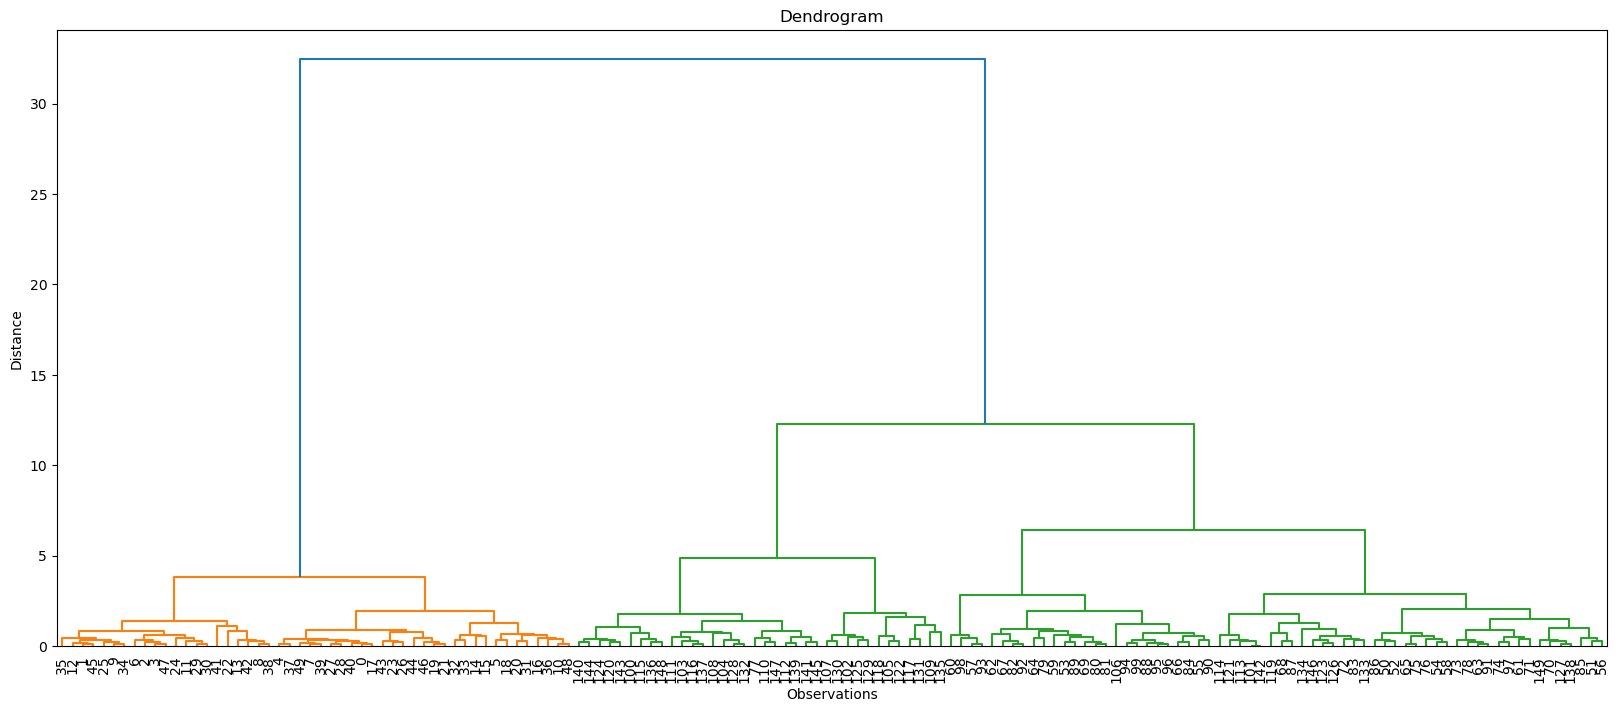

In [16]:
plt.figure(figsize = (20,8))
plt.title("Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10);

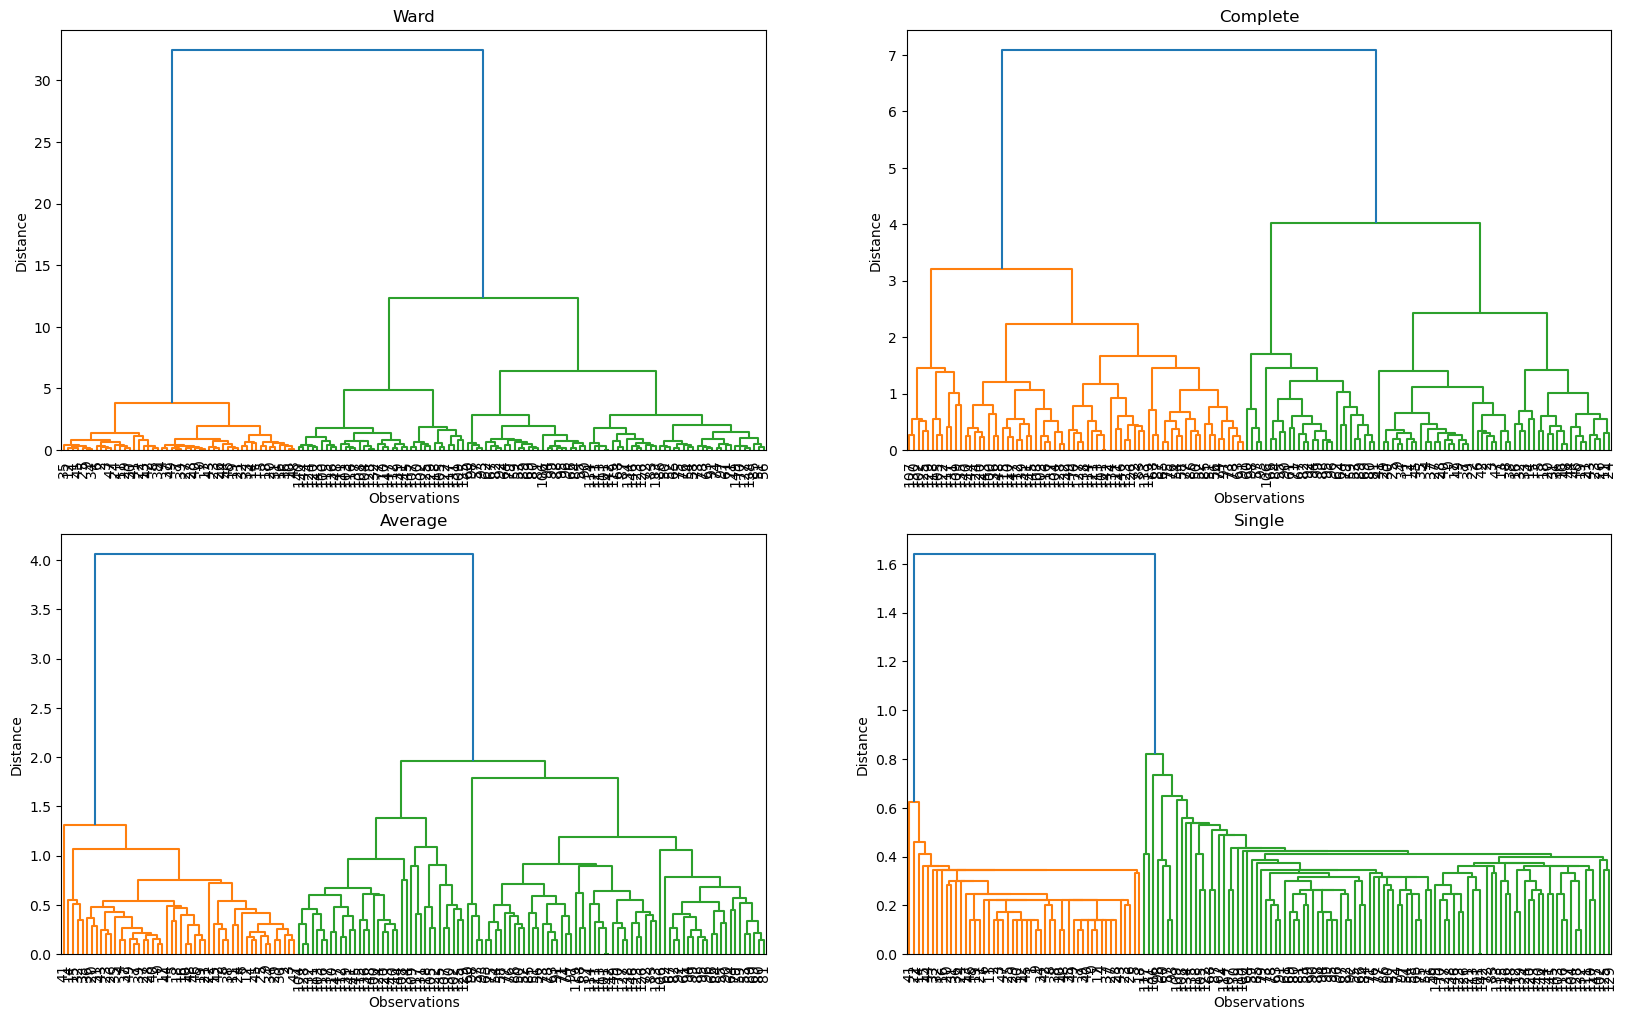

In [17]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10);

# kümeler içi minimum kümeler arası maksimum mesafeyi ward sağladığından ward ile devam edeceğiz.
# dendogramın mavi çizgi ile gösterdiği bize tavsiye ettiği küme sayısıdır. Ancak dendogram kümeler arası mesafeyi max 
# yapacak şekilde bize bir öneride bulunur ama biz yine sadece dendogramdan değil. scatter plot ve silhouette scoredan
# faydalanıp ona göre karar vereceğiz.

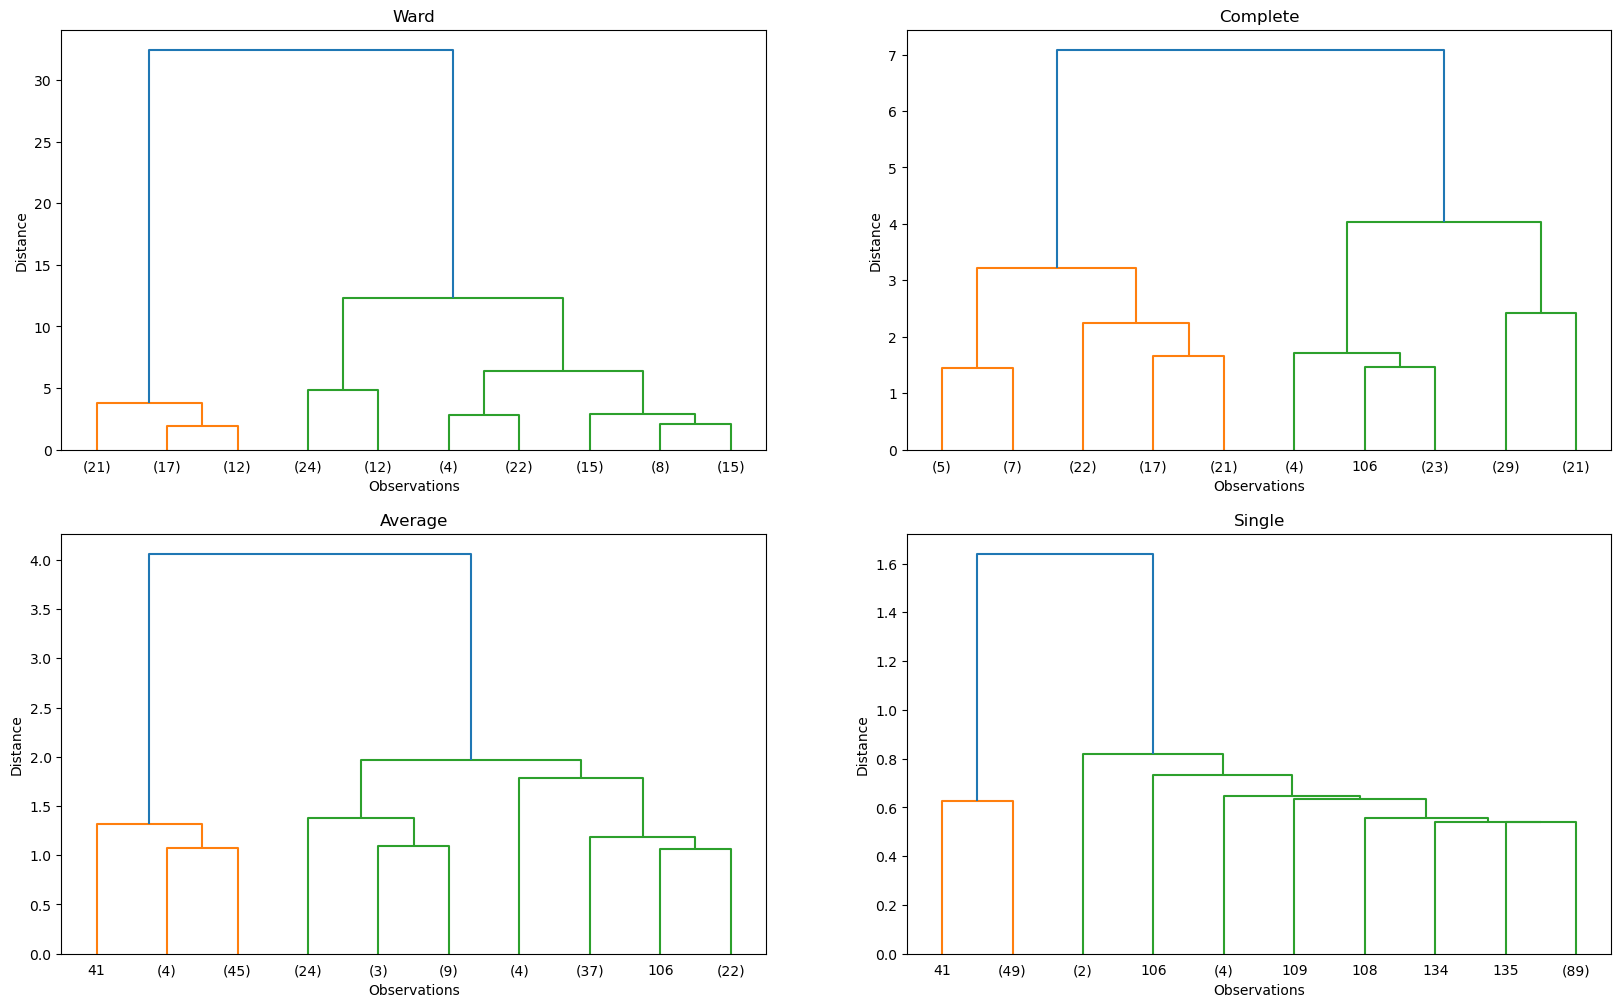

In [18]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10, truncate_mode='lastp', p=10)#p sonda kac tane bölünme olsun.

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10, truncate_mode='lastp', p=10);

# truncate_mode='lastp' ve p=10 ayarlanarak dendogramın sadece son 10 kümeyi bize gösterecek şekilde sadeleştirme yapması
# sağlanır.

## Hierarchical Clustering (Agglomerative)

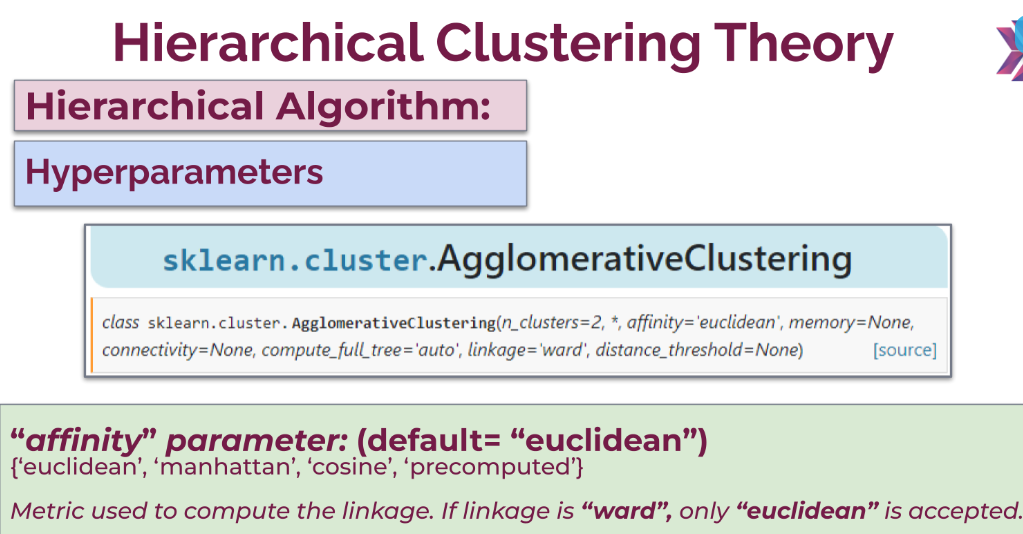

- Ideal clustering is characterised by minimal intra cluster distance and maximal inter cluster distance

In [19]:
from sklearn.cluster import AgglomerativeClustering

In [20]:
model = AgglomerativeClustering(n_clusters=2, affinity = "euclidean", linkage = "ward")
# default değerleri ile modeli çalıştırıyoruz.

In [21]:
model.fit_predict(X)
# k-means'te olduğu hierarchical clustarın predict özelliği yoktur. Tek başına çalışmaz

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [22]:
model.labels_
# fit veya fit_predict yaptıktan sonra label_ attirbute ile clusterları görebiliriz.

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### S(Silhouette) Score

- If the ground truth labels are not known, evaluation must be performed using the model itself. (One of the evaluation method is Silhouette Coefficient)
- A higher Silhouette Coefficient score relates to a model with better defined clusters. 
- a :The mean distance between a sample and all other points in the same class.
  b: The mean distance between a sample and all other points in the next nearest cluster.

s = (b-a) / max(a,b)

In [23]:
from sklearn.metrics import silhouette_score

In [24]:
K = range(2,10)

for k in K:
    model = AgglomerativeClustering(n_clusters = k)
    model.fit(X)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(X, model.labels_)}')

# n_clusters=2 'de silhouette score yüksek AMA ;
# cluster sayısını 2 seçersem scatterplata göre kümelerden biri çok  geniş bir alana yayılacak.
# O yüzden n_clusters=3 seçebilirmiyiz diye düşünüyoruz. Dendogram ward'da 3 cluster içinde kümeler içi mesafe minumum
# kümeler arası mesafenin max seviyerlerde olduğunu gördüğümüzden 3'ü seçiyoruz.
# burada hesaplanan silhouette score bütün gözlemlerin ortalamasıdır (clusterlara göre)

Silhouette Score for 2 clusters: 0.6867350732769781
Silhouette Score for 3 clusters: 0.5543236611296426
Silhouette Score for 4 clusters: 0.4889670857554699
Silhouette Score for 5 clusters: 0.48438258927906047
Silhouette Score for 6 clusters: 0.3592376192603092
Silhouette Score for 7 clusters: 0.3422071936620507
Silhouette Score for 8 clusters: 0.34359065991195437
Silhouette Score for 9 clusters: 0.33048863528746636


In [25]:
model2 = AgglomerativeClustering(n_clusters=3, affinity = "euclidean", linkage = "ward")
model2.fit_predict(X)

# n_cluster=3'e göre modeli yeniden kuruyoruz.

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int64)

In [26]:
model2.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int64)

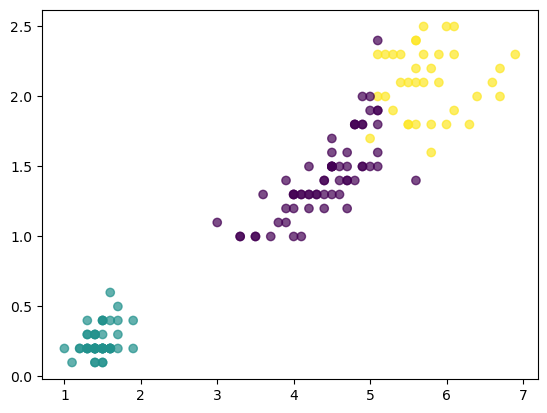

In [27]:
plt.scatter(X["petal_length"], X["petal_width"], c = model2.labels_, cmap = "viridis", alpha =0.7)

In [28]:
labels = pd.read_csv("label.csv")
labels

# müşteriden laballamasını istedik. dataları labellayıp label.csv olarak teslim etti.

,species
0,setosa
1,setosa
2,setosa
3,setosa
4,setosa
...,...
145,virginica
146,virginica
147,virginica
148,virginica


In [29]:
labels.value_counts()

species   
setosa        50
versicolor    50
virginica     50
dtype: int64

In [30]:
X["predicted_clusters"] = model2.labels_
X["labels"] = labels
X

#df'e modelin tahmin ettiği cluster ile gerçek labelları atıyorum.

,sepal_length,sepal_width,petal_length,petal_width,predicted_clusters,labels
0,5.1,3.5,1.4,0.2,1,setosa
1,4.9,3.0,1.4,0.2,1,setosa
2,4.7,3.2,1.3,0.2,1,setosa
3,4.6,3.1,1.5,0.2,1,setosa
4,5.0,3.6,1.4,0.2,1,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,0,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [31]:
ct = pd.crosstab(X["predicted_clusters"], X["labels"])
ct

# çapraz doğrulama ile gerçek labelların ne kadarını tutturduğumuzu görüyoruz.

labels,setosa,versicolor,virginica
predicted_clusters,,,
0,0,49,15
1,50,0,0
2,0,1,35


## ARI Score

- The Adjusted Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
- The value of ARI indicates no good clustering if it is close to zero or negative, and a good cluster if it is close to 1.

In [32]:
#elimizde label olduğu için arı score a bakabiliyoruz.. aksi halde bakamazdık.

In [33]:
from sklearn.metrics.cluster import adjusted_rand_score

In [34]:
adjusted_rand_score(X.labels, X.predicted_clusters)

# adjusted_rand_score ; accuracy değildir adjusted_rand_score hataları cezalandırır.
# adjusted_rand_score'a bakabilmek için elimizde bir şekilde gerçek label'ların en azından belirli bir kısmının olması lazım.

0.7311985567707746

## Visualization Clusters

In [35]:
X_actuel_labels = X.labels.map({"versicolor":0, "setosa":1,"virginica":2})
X_actuel_labels

# scatter plot çizebilmek için string type'ları numeric'e çeviriyorum crosstab'e göre bu dönüşümleri yapıyorum.

0      1
1      1
2      1
3      1
4      1
      ..
145    2
146    2
147    2
148    2
149    2
Name: labels, Length: 150, dtype: int64

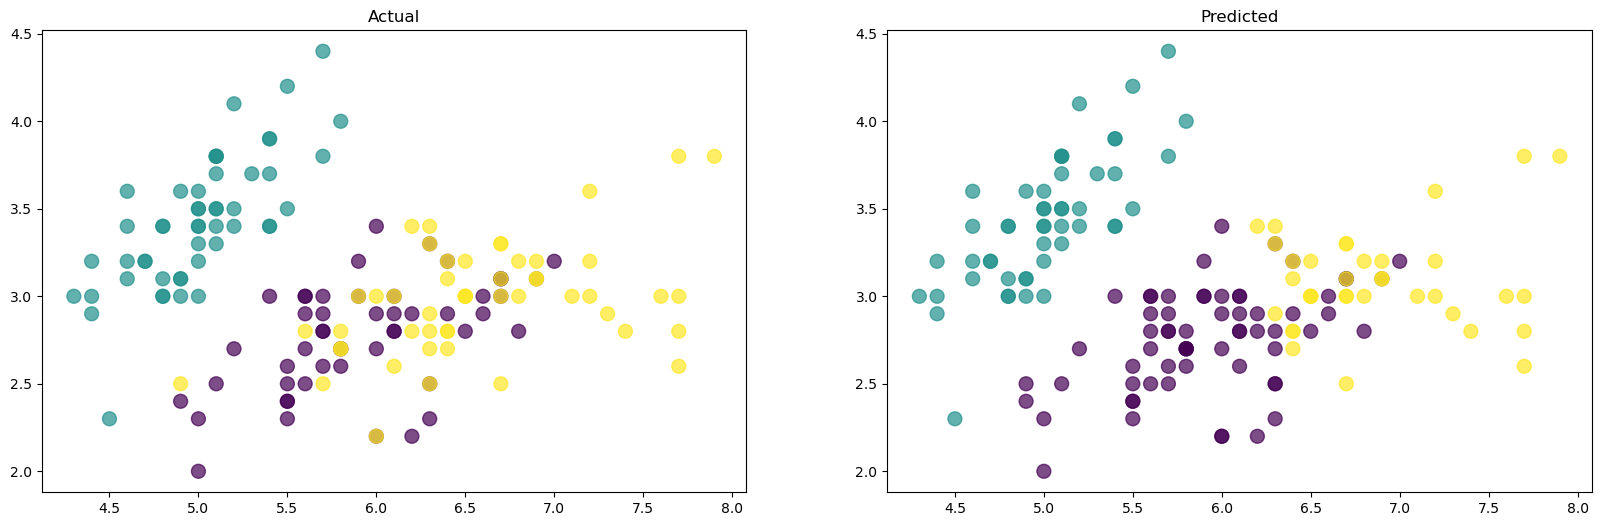

In [36]:
plt.figure(figsize = (20,6))

plt.subplot(121)
plt.scatter(X["sepal_length"], X["sepal_width"], c = X_actuel_labels, cmap = "viridis", alpha=0.7, s=100)
plt.title("Actual")

plt.subplot(122)
plt.scatter(X["sepal_length"], X["sepal_width"], c = X.predicted_clusters, cmap = "viridis", alpha=0.7, s=100)
plt.title("Predicted");

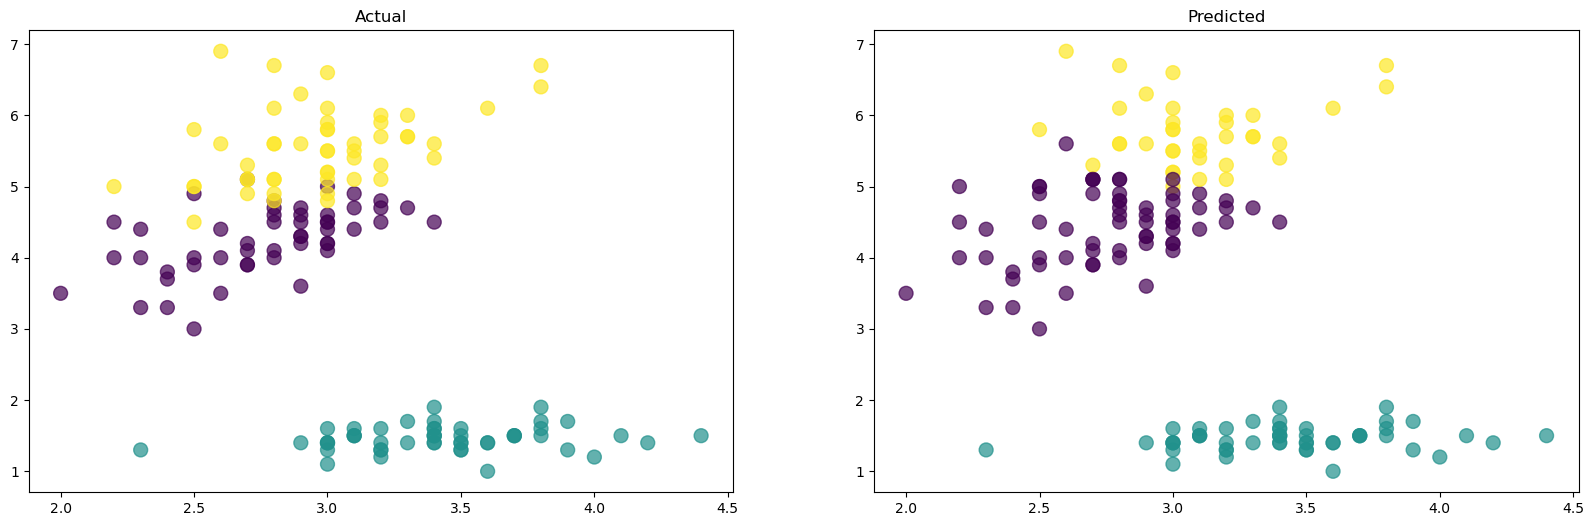

In [37]:
plt.figure(figsize = (20,6))

plt.subplot(121)
plt.scatter(X["sepal_width"], X["petal_length"], c = X_actuel_labels, cmap = "viridis", alpha=0.7, s=100)
plt.title("Actual")

plt.subplot(122)
plt.scatter(X["sepal_width"], X["petal_length"], c = X.predicted_clusters, cmap = "viridis", alpha=0.7, s=100)
plt.title("Predicted");

## Remodeling according to discriminating features

In [58]:
X.head()

,sepal_length,sepal_width,petal_length,petal_width,predicted_clusters,labels
0,5.1,3.5,1.4,0.2,1,setosa
1,4.9,3.0,1.4,0.2,1,setosa
2,4.7,3.2,1.3,0.2,1,setosa
3,4.6,3.1,1.5,0.2,1,setosa
4,5.0,3.6,1.4,0.2,1,setosa


In [59]:
clus_pred = X.iloc[:, [0, 1, 2, 3, 4]].groupby("predicted_clusters").mean().T
clus_pred

predicted_clusters,0,1,2
sepal_length,5.920312,5.006,6.869444
sepal_width,2.751562,3.428,3.086111
petal_length,4.420312,1.462,5.769444
petal_width,1.434375,0.246,2.105556


<AxesSubplot:>

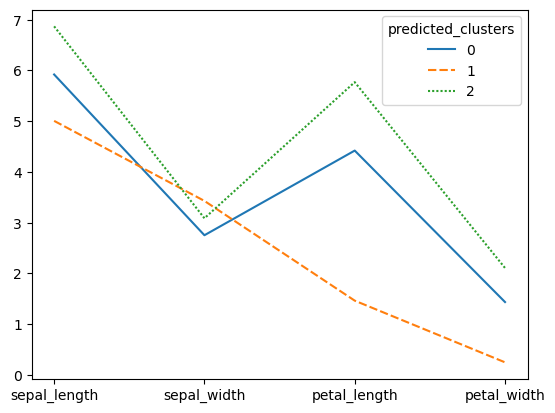

In [60]:
sns.lineplot(data = clus_pred)

<AxesSubplot:xlabel='predicted_clusters', ylabel='petal_width'>

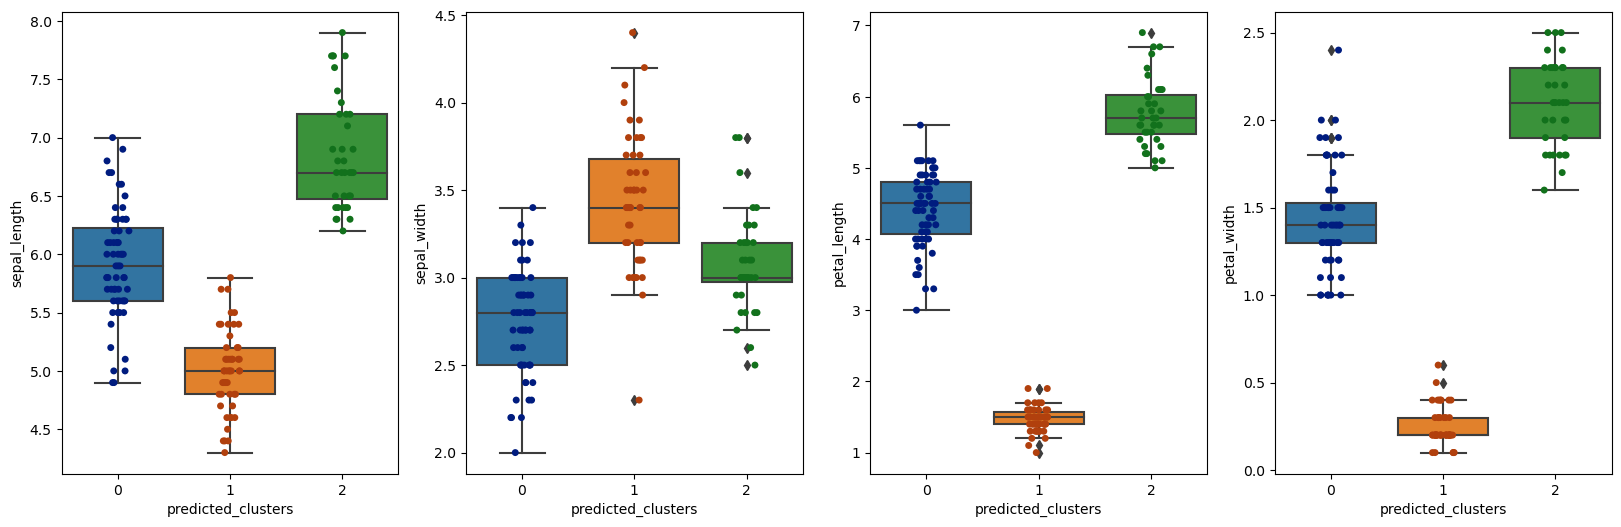

In [61]:
plt.figure(figsize = (20,6))

plt.subplot(141)
sns.boxplot(y = "sepal_length", x = "predicted_clusters", data = X)
sns.stripplot(y = "sepal_length", x = "predicted_clusters", data = X, palette="dark")

plt.subplot(142)
sns.boxplot(y = "sepal_width", x = "predicted_clusters", data = X)
sns.stripplot(y = "sepal_width", x = "predicted_clusters", data = X, palette="dark")

plt.subplot(143)
sns.boxplot(y = "petal_length", x = "predicted_clusters", data = X)
sns.stripplot(y = "petal_length", x = "predicted_clusters", data = X, palette="dark")

plt.subplot(144)
sns.boxplot(y = "petal_width", x = "predicted_clusters", data = X)
sns.stripplot(y = "petal_width", x = "predicted_clusters", data = X,palette="dark")


In [62]:
#yukarıda petallength ve petal width iyi ayrılmış diğerleri iyi ayrılmamış , girift durum söz konusu diyebiliriz..

In [63]:
X2 = X.iloc[:, [2,3]]
X2

,petal_length,petal_width
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


### Hopkins Test

In [64]:
hopkins(X2, X2.shape[0])
#4 feature ile baktığımızda hopkins 0.16 idi. bu durumda sıfıra daha yakın oldugu için 2 featurelı hli daha iyi sonuç elde edebiliriz..

0.09487511296018009

### Dendrogram

In [65]:
hc_ward = linkage(y = X2, method = "ward")
hc_complete = linkage(X2, "complete")
hc_average = linkage(X2, "average")
hc_single = linkage(X2, "single")

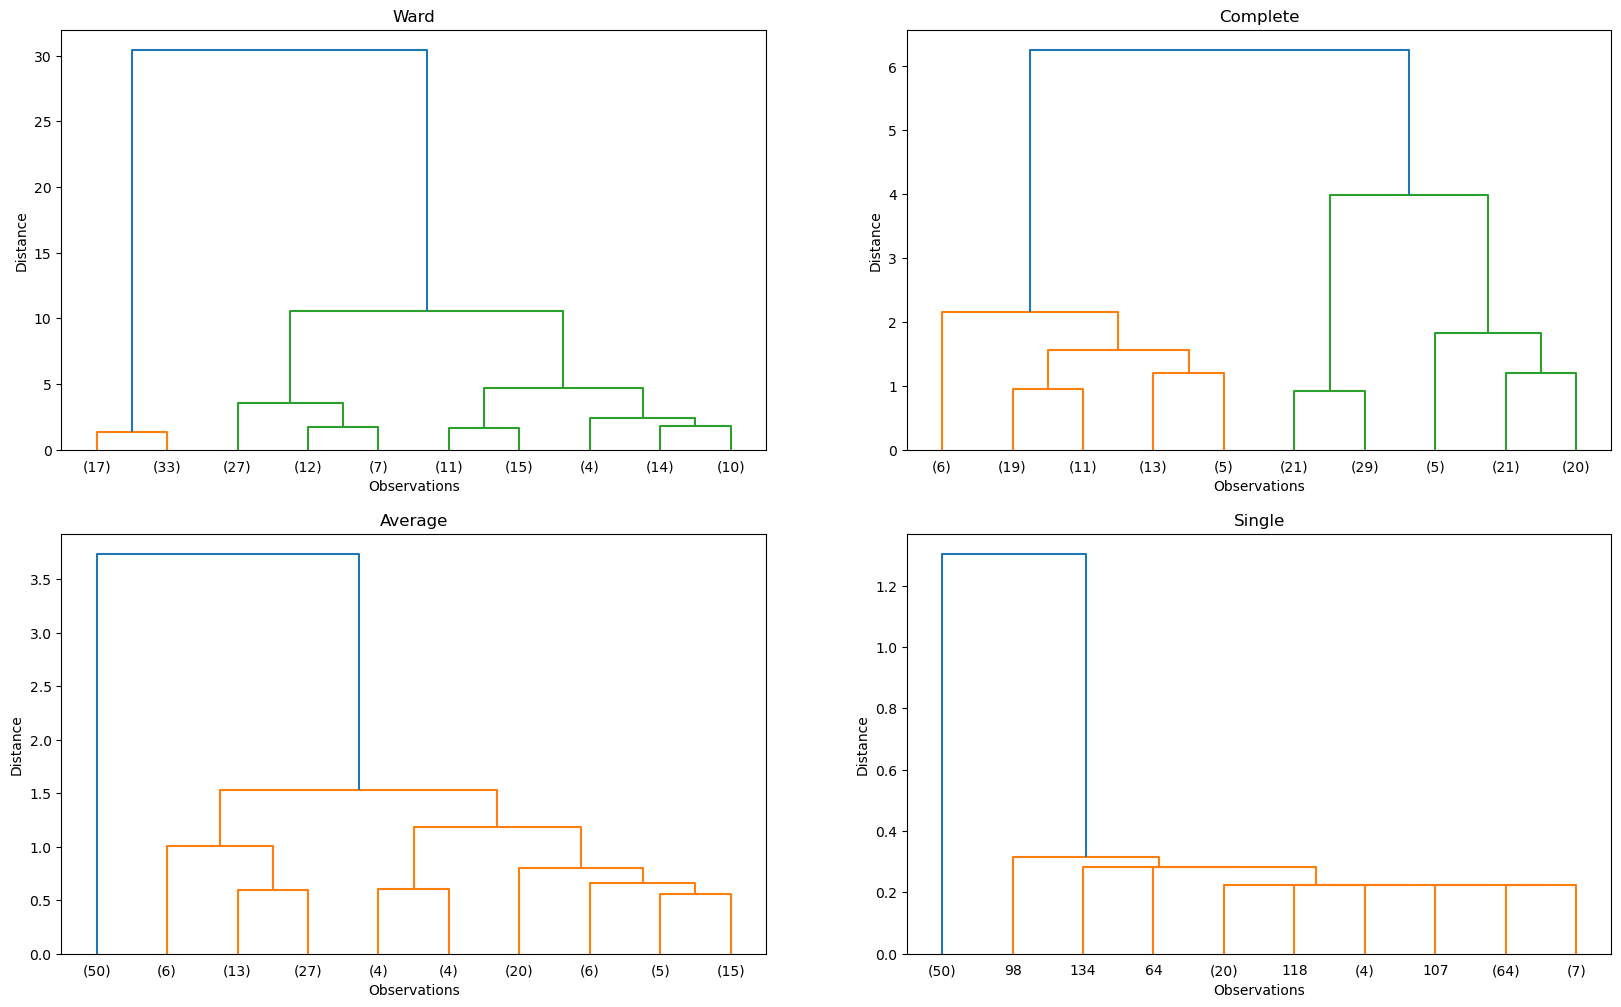

In [66]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10, truncate_mode='lastp', p=10);

In [67]:
# yukarıda hepsinde distance a baktığımızda  yine ward daha uygun bir parametre seçimi olacak.

### S(Silhouette) Score

In [68]:
K = range(2,10)

for k in K:
    model = AgglomerativeClustering(n_clusters = k)
    model.fit_predict(X2)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(X2, model.labels_)}')
    # 3 ü tercih ediyoruz..

Silhouette Score for 2 clusters: 0.7669465622832407
Silhouette Score for 3 clusters: 0.6573949269807601
Silhouette Score for 4 clusters: 0.5895284482019625
Silhouette Score for 5 clusters: 0.5781917220160803
Silhouette Score for 6 clusters: 0.5747380907871611
Silhouette Score for 7 clusters: 0.5830818099432683
Silhouette Score for 8 clusters: 0.5678904786644875
Silhouette Score for 9 clusters: 0.5469910006642241


## Final model

In [69]:
final_model = AgglomerativeClustering(n_clusters=3, affinity = "euclidean", linkage = "ward")
clusters = final_model.fit_predict(X2)

In [70]:
X2["predicted_clusters"] = clusters
X2["labels"] = labels
X2

,petal_length,petal_width,predicted_clusters,labels
0,1.4,0.2,1,setosa
1,1.4,0.2,1,setosa
2,1.3,0.2,1,setosa
3,1.5,0.2,1,setosa
4,1.4,0.2,1,setosa
...,...,...,...,...
145,5.2,2.3,0,virginica
146,5.0,1.9,0,virginica
147,5.2,2.0,0,virginica
148,5.4,2.3,0,virginica


In [71]:
X2_ct = pd.crosstab(X2["predicted_clusters"], X2["labels"])
X2_ct

labels,setosa,versicolor,virginica
predicted_clusters,,,
0,0,5,49
1,50,0,0
2,0,45,1


In [72]:
ct

labels,setosa,versicolor,virginica
predicted_clusters,,,
0,0,49,15
1,50,0,0
2,0,1,35


In [73]:
X2_labels = X2.labels.map({"virginica":0, "setosa":1,"versicolor":2})
X2_labels

0      1
1      1
2      1
3      1
4      1
      ..
145    0
146    0
147    0
148    0
149    0
Name: labels, Length: 150, dtype: int64

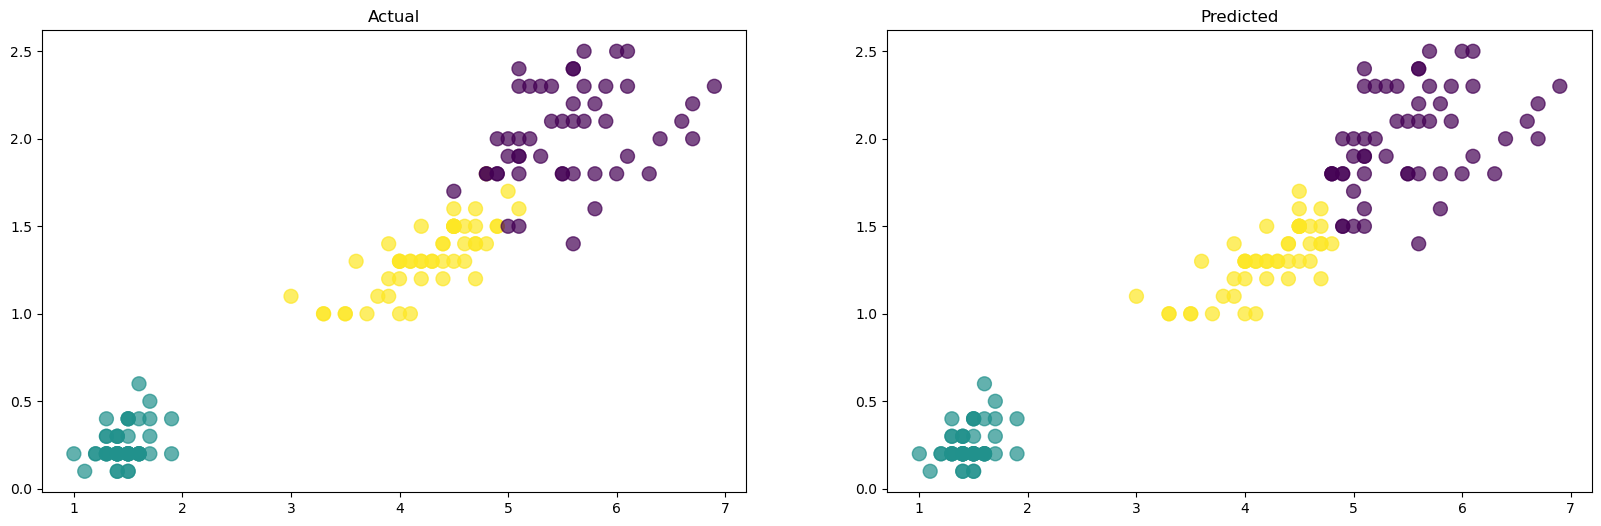

In [74]:
plt.figure(figsize = (20,6))

plt.subplot(121)
plt.scatter(X2["petal_length"], X2["petal_width"], c = X2_labels, cmap = "viridis", alpha=0.7, s=100)
plt.title("Actual")

plt.subplot(122)
plt.scatter(X2["petal_length"], X2["petal_width"], c = X2.predicted_clusters, cmap = "viridis", alpha=0.7, s=100)
plt.title("Predicted");

### ARI Score

In [75]:
adjusted_rand_score(X2.labels, X2.predicted_clusters) # 0.7311985567707746

0.8857921001989628

## Prediction cluster of new data

In [78]:
new_data = [[1.7, 0.2], [2.3, 0.5]]

In [79]:
final_model.predict(new_data)

# hierarchical clusterın predict attribute olmadığından yeni bir gözlem predict ettirmek istiyorsak. Datamıza bu gözlemleri
# ilave edip dendogramı yeniden çalıştırıp dendogram sonrası karar verdiğimiz cluster sayısından sonra hangi clustera
# atandığını görebiliriz.

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

In [ ]:
#burada yeni datayı hemen tahmin edeyim diyemiyoruz. hangi class a ait olduğunu bulmak için yukarıdaki dataya 
#dahil edip yeniden yapıyoruz aşamaları.. bu da bir dezavantaj diyebiliriz